# <font color='magenta'>Fig_2b_Kernels_vs_BG</font> 

This script is used to analyze the wheat kernel HSI data (VISNIR), written by Kshitiz Dhakal.

### Health status:

Kernel(Healthy-looking(75) and Infected-looking(53))- 128

Background-68 data points

Total: 196

### Labels:   
   Kernel(Healthy-looking and Infected-looking)-1
   
   Background-0

### Packages and versions used:

Python 3.8.6

scipy: 1.6.0

numpy: 1.18.5

matplotlib: 3.3.3

pandas: 1.2.1

sklearn: 1.0.2

xgboost: 1.5.1

seaborn: 0.11.1

### Import libraries and check their versions

In [1]:
import sys
print('Python: {}'.format(sys.version))
import scipy
print('scipy: {}'.format(scipy.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import matplotlib
print('matplotlib: {}'.format(numpy.__version__))
import pandas
print('pandas: {}'.format(pandas.__version__))
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xgboost
print('xgboost: {}'.format(xgboost.__version__))

Python: 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 04:30:06) [MSC v.1916 64 bit (AMD64)]
scipy: 1.6.0
numpy: 1.23.4
matplotlib: 1.23.4
pandas: 1.2.1
sklearn: 1.0.2
xgboost: 1.5.1


### Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB #Gaussian Naive Bayes for generative and supervised
from sklearn.neighbors import KNeighborsClassifier #K Nearest Neighbors for discriminative and supervised
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis#Linear Discriminant Analysis for discriminative and supervised
from sklearn.neural_network import MLPClassifier #Multi layer Perceptron discriminative and supervised
from sklearn.cross_decomposition import PLSRegression #Partrial Least Squares Regression for discriminative and supervised
from sklearn.ensemble import RandomForestClassifier #Random Forest for discriminative and supervised
from sklearn import svm # Support Vector Machine
from sklearn.svm import SVC #discriminative and supervised
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting an ensembel method
from sklearn.metrics import classification_report 
from sklearn.model_selection import KFold # for five fold cross validation
from sklearn.metrics import confusion_matrix # calcuate confusion matrix
from statannotations.Annotator import Annotator

### Load and pre-process the dataset 
#### The original dataset was labeled taking background pixels as 0 and kernel pixels as 1

In [3]:
dataset = pd.read_csv('../Input/input_hsi_2022_coded_two_classes_refined.csv', index_col=0)

#### Extract information from the orginal dataset

In [4]:
array = dataset.values # save all the values of datasets as array
labels = array[:,300] # save the labels
features = array[:,0:300] # save the reflectance values of classified pixels as features
features = features/10000 # normalize features
wavelengths = dataset.columns[0:300] # save the column names as wavelengths

#### Rebuild the dataframe to visualize hyperspectral signatures

In [5]:
df = pd.DataFrame(features) #Create a new df having reflecance values only
df_wave = pd.DataFrame(wavelengths) # Add wavelengths in the df
df_wave.columns = ['Wavelength(nm)'] # Add a new column named Wavelength(nm) 
df.columns = df_wave['Wavelength(nm)'] # Add the previous column to the df
df['Label'] = labels # Add labels to the df
df.head() #Display head of df

Wavelength(nm),385.63,387.65,389.67,391.68,393.7,395.72,397.74,399.76,401.79,403.81,...,1009,1011.27,1013.54,1015.81,1018.08,1020.35,1022.63,1024.9,1027.18,Label
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1009,0.0275,0.0000,0.0178,...,0.0000,0.0000,0.000,0.1851,0.0000,0.0000,0.0000,0.0,0.0,0
1,0.0000,0.0000,0.0968,0.0357,0.0000,0.0777,0.1292,0.1058,0.0565,0.0919,...,0.0911,0.0000,0.000,0.0000,0.0000,0.0000,0.2651,0.0,0.0,0
2,0.0000,0.0483,0.2063,0.1298,0.2139,0.2161,0.2330,0.1878,0.2825,0.2773,...,0.0852,0.0911,0.102,0.0000,0.1074,0.1255,0.2678,0.0,0.0,0
3,0.0000,0.0000,0.0000,0.0000,0.1554,0.1276,0.0696,0.0568,0.0453,0.0923,...,0.0000,0.2013,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0
4,0.1298,0.0000,0.0769,0.0626,0.0000,0.0000,0.0348,0.0557,0.0000,0.0380,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0


### Deploy ML models to train, predict and get accuracy of the prediction

#### Get a list of models to evaluate and define evaluation method

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, StratifiedKFold
def get_models():
    models = []
    models.append(('NB', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('MLPNN', MLPClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVML', SVC(kernel='linear')))
    models.append(('SVMR', SVC(kernel='rbf')))
    models.append(('GBoost', GradientBoostingClassifier()))
    models.append(('PLSDA', PLSRegression(n_components=2)))
    return models

# Evaluate the above models using repeated kfold-cross-validation, which estimates the model accurary/performance based on running k-fold a number of times and calculating the performance across all the repeats. Suited to datasets of smaller scale
def evaluate_models(models,features, labels):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(models, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

def pls_da(features, labels):
    plsda = PLSRegression(n_components=2) # Two classes, BG and Kernel
    plsda.fit(features, labels) # Fit the training set
    binary_prediction = (plsda.predict(features)[:,0] > 0.5).astype('uint8') ## Fit the training set
    return  binary_prediction

def evaluate_plsda(features,labels):
    accuracy = []
    cval = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    for train, test in cval.split(features, labels):
        y_pred = pls_da(features, labels) #y_pred = pls_da(X_train, y_train, X_test)
        accuracy.append(accuracy_score(y_true=labels, y_pred=y_pred))
    return np.array(accuracy)

#### Compare the classification accuracy of all models using all wavelengths

>NB 0.990 (0.020)
>KNN 1.000 (0.000)
>LDA 0.893 (0.065)
>MLPNN 1.000 (0.000)
>RF 1.000 (0.000)
>SVML 1.000 (0.000)
>SVMR 1.000 (0.000)
>GBoost 1.000 (0.000)
>PLSDA 1.000 (0.000)


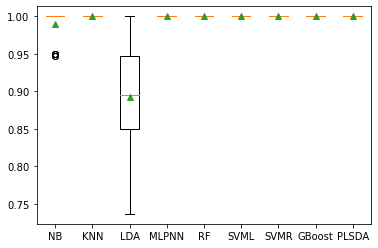

In [7]:
models = get_models()
results = [] ## Store evaluation results
names = []
for name, model in models:
    if name == "PLSDA":
        Eval_classimodel = evaluate_plsda( features, labels)
        results.append(Eval_classimodel)
    else:
        Eval_classimodel = evaluate_models(model,features, labels)
        results.append(Eval_classimodel)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(Eval_classimodel), std(Eval_classimodel)))

plt.boxplot(results, labels=names, showmeans=True)
#plt.savefig('2b_2class_severity_8_MLs_pixels_comparision.pdf')
plt.show()

#Middle one is yhe Q2 or the median
#Lower Q1 - whis*(Q3-Q1), and the upper whisker at the highest datum below Q3 + whis*(Q3-Q1),
#where Q1 and Q3 are the first and third quartiles. The default value of whisker = 1.5

#### Preprocessing evaluation results

In [8]:
# Build a dataframe including cross validation accuracy for each machine learning methods
df_clf_accuracy = pd.DataFrame(results) # Each fold had 30 datapounts(wavelengths) and we had 10 fold so altogether there were 300 datapoints
df_clf_accuracy = df_clf_accuracy.T # Transpose the dataframe
df_clf_accuracy.columns = names #Name the dataframe columns
df_clf_accuracy
#df_clf_accuracy.to_csv(r'../results/b_2class_severity_8_MLs_pixels_comparisionn_all_clf_accuracy.csv', encoding='utf-8', header='true')

,NB,KNN,LDA,MLPNN,RF,SVML,SVMR,GBoost,PLSDA
0,0.950000,1.0,0.900000,1.0,1.0,1.0,1.0,1.0,1.0
1,1.000000,1.0,0.900000,1.0,1.0,1.0,1.0,1.0,1.0
2,1.000000,1.0,0.850000,1.0,1.0,1.0,1.0,1.0,1.0
3,1.000000,1.0,0.950000,1.0,1.0,1.0,1.0,1.0,1.0
4,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
5,1.000000,1.0,0.850000,1.0,1.0,1.0,1.0,1.0,1.0
6,0.947368,1.0,0.894737,1.0,1.0,1.0,1.0,1.0,1.0
7,1.000000,1.0,0.894737,1.0,1.0,1.0,1.0,1.0,1.0
8,1.000000,1.0,0.894737,1.0,1.0,1.0,1.0,1.0,1.0
9,1.000000,1.0,0.894737,1.0,1.0,1.0,1.0,1.0,1.0


###  Post hoc pairwise comparison

#### Prepare dataset for anova and pairwise comparison

In [9]:
df1=df_clf_accuracy # 30*8
df2=df1.stack() #  240*1 folds*methods
df3=df2.reset_index() # Folds*methods*number of methods
method=df3['level_1'] #Methods names as independent (predictor) variable
acc_value=df3.iloc[:,2] #Accuracy value from 3rd column as dependent (response) variable
dfanova=pd.DataFrame(method) #Methods names added to dfnnova df
dfanova['Accuracy']=acc_value #Accuracy value  added to dfnnova df
dfanova.columns=['Method','Accuracy'] # Column names to dfannova df

#### Perform Parametric ANOVA with post hoc tests

In [10]:
lm = sfa.ols('Accuracy ~ C(Method)', data=dfanova).fit() # Fit OLS for method(predictor) and acc_value (response variable)
anova = sa.stats.anova_lm(lm) # Run ANOVA for OLS method
anova # The results tell us that there is a significant difference between groups means (p = 3.780522e-54), but does not tell us the exact group pairs which are different in means.

,df,sum_sq,mean_sq,F,PR(>F)
C(Method),8.0,0.301403,0.037675,71.21786,3.039810e-61
Residual,261.0,0.138073,0.000529,NaN,NaN


#### Perform Post hoc tests (To obtain pairwise differences, carry out a posteriori (post hoc) analysis)
##### Tukey test applied pairwisely gives p values

In [11]:
#sp.posthoc_ttest(dfanova, val_col='acc_value', group_col='method')
#pairwise_tukeyhsd
phoc=sp.posthoc_tukey(dfanova, val_col='Accuracy', group_col='Method') # perform p hoc analysis using Accuracy and Method by applying Tukey test pairwisely
remove = np.tril(np.ones(phoc.shape), k=0).astype("bool") #Return a copy of an array with elements above the k-th diagonal zeroed
phoc[remove] = np.nan # remove NAs from phoc
molten_df = phoc.melt(ignore_index=False).reset_index().dropna() #reset the indices and melt/stack the phoc results

### Plot the boxplots to see the pairwise differences

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NB vs. KNN: Custom statistical test, P_val:7.106e-01
KNN vs. LDA: Custom statistical test, P_val:1.000e-03
LDA vs. MLPNN: Custom statistical test, P_val:1.000e-03
MLPNN vs. RF: Custom statistical test, P_val:9.000e-01
RF vs. SVML: Custom statistical test, P_val:9.000e-01
SVML vs. SVMR: Custom statistical test, P_val:9.000e-01
SVMR vs. GBoost: Custom statistical test, P_val:9.000e-01
GBoost vs. PLSDA: Custom statistical test, P_val:9.000e-01
NB vs. LDA: Custom statistical test, P_val:1.000e-03
KNN vs. MLPNN: Custom statistical test, P_val:9.000e-01
LDA vs. RF: Custom statistical test, P_val:1.000e-03
MLPNN vs. SVML: Custom statistical test, P_val:9.000e-01
RF vs. SVMR: Custom statistical test, P_val:9.000e-01
SVML vs. GBoost: Custom statistical test, P_val:9.000e-01
SVMR vs. PLSDA: Custom statistical test, P_

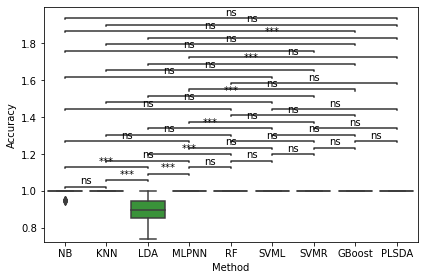

In [12]:
ax=sns.boxplot(data=dfanova, x="Method", y="Accuracy") # Provide the data, and axes for the graph
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()] #store pairs of methods from all methods of molten_df
p_values = [i[1]["value"] for i in molten_df.iterrows()] #storte p_values from molten_df
annotator = Annotator(ax, pairs, data=dfanova, x="Method", y="Accuracy") # provide data to the annotator
annotator.configure(text_format="star", loc="inside") # put star and give the location of the star
annotator.set_pvalues_and_annotate(p_values) #p_values = list or array of p-values for each pair comparison.
#plt.savefig('3b1_2class_severity_pairwise_accuracy_comparison.pdf') # save the plot
plt.tight_layout() # To cover much more space
plt.show()

#### Include pairwise comparison results in the accuracy vs model graph

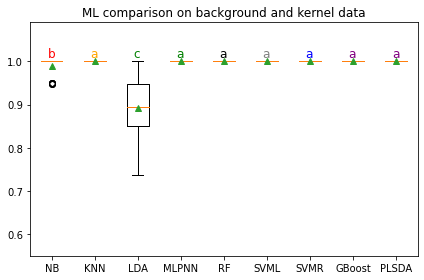

In [14]:
plt.boxplot(results, labels=names, showmeans=True)

plt.text(0.90, 1.01,'b',color='red', fontsize=12)
plt.text(1.9, 1.01,'a',color='orange', fontsize=12)
plt.text(2.9, 1.01,'c',color='green', fontsize=12)
plt.text(3.9, 1.01,'a',color='green', fontsize=12)
plt.text(4.9, 1.01,'a',color='black', fontsize=12)
plt.text(5.9, 1.01,'a',color='grey', fontsize=12)
plt.text(6.9, 1.01,'a',color='blue', fontsize=12)
plt.text(7.9, 1.01,'a',color='purple', fontsize=12)
plt.text(8.9, 1.01,'a',color='purple', fontsize=12)

plt.ylim([0.55, 1.09])
plt.title('ML comparison on background and kernel data')
plt.tight_layout()
plt.savefig('../Output/Fig2b_2class_severity_8_MLs_pixels_pairwise_accuracy_comparison.pdf')
plt.show()